In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import os
from src.progress_bar import printProgressBar

for dirname, _, filenames in os.walk('../../data/lyrics'):
    for filename in filenames:
        print(os.path.join(dirname, filename).replace("\\","/"))

print(50*'-')

for dirname, _, filenames in os.walk('../../data/billboard'):
    for filename in filenames:
        print(os.path.join(dirname, filename).replace("\\","/"))


../../data/lyrics/artist_song_lyrics.csv
../../data/lyrics/bb-t100-lyrics.csv
../../data/lyrics/bb-t100-lyrics_new.csv
../../data/lyrics/bb_t100_lyrics_en.csv
../../data/lyrics/bb_t100_lyrics_en_v2.csv
../../data/lyrics/bb_t100_lyrics_en_v3.csv
../../data/lyrics/corona-lyrics.csv
../../data/lyrics/lyrics_invalid.json
../../data/lyrics/lyrics_invalid_updated.csv
../../data/lyrics/backups/artist_song_lyrics.csv
../../data/lyrics/backups/artist_song_lyrics_bak.csv
../../data/lyrics/backups/bb-t100-lyrics.csv
../../data/lyrics/backups/bb-t100-lyrics_new.csv
../../data/lyrics/backups/bb_t100_lyrics_en.csv
../../data/lyrics/backups/bb_t100_lyrics_en_v2.csv
../../data/lyrics/backups/bb_t100_lyrics_en_v3.csv
../../data/lyrics/backups/corona-lyrics.csv
../../data/lyrics/backups/lyrics_invalid_updated.csv
--------------------------------------------------
../../data/billboard/bb_t100_en.csv
../../data/billboard/billboard.csv
../../data/billboard/billboard_top_100_2020.csv
../../data/billboard/ba

In [2]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_colwidth', 30)
lyrics = pd.read_csv('../../data/lyrics/bb_t100_lyrics_en_v2.csv', index_col=0, encoding='utf-8')
lyrics.tail()

,billboard_id,lyrics_id,artist,first_artist,song,weeks_on_chart,peak_rank,lyrics,url,length,word_count,language,language_score,first_appearance,genius_id,release_date
1317,10459,1317,Eminem,Eminem,Gnat,1.0,60.0,"Yeah, yeah, sick\n(d.a. go...",https://genius.com/Eminem-...,5762,1113,en,0.999999,2021-01-02,6285862.0,NaN
1318,10477,1318,Gabby Barrett,Gabby Barrett,The First Noel,1.0,78.0,"The First Noel, the Angels...",https://genius.com/Gabby-b...,666,132,en,0.999996,2021-01-02,6086107.0,2020-10-23
1319,10483,1319,Popp Hunna,Popp Hunna,Adderall (Corvette Corvette),1.0,84.0,"(Bitch)\nCorvette, Corvett...",https://genius.com/Popp-hu...,2366,515,en,0.999998,2021-01-02,6110220.0,2020-10-15
1320,10492,1320,Lil Durk,Lil Durk,Backdoor,1.0,93.0,(Malik on the beat)\n(Ayo ...,https://genius.com/Lil-dur...,2778,547,en,0.999996,2021-01-02,6270159.0,2020-12-21
1321,10497,1321,DDG,DDG,Moonwalking In Calabasas,1.0,98.0,Ballin' since I was a jit\...,https://genius.com/Ddg-moo...,2786,549,en,0.999996,2021-01-02,5800223.0,2020-07-25


In [3]:
bb_t100 = pd.read_csv('../../data/billboard/bb_t100_en.csv', index_col=0)
bb_t100.head()

,billboard_id,lyrics_id,song,artist,peak_rank,rank_last_week,weeks_on_chart,rank,date,first_appearance,language,language_score
0,0,0,"Thank U, Next",Ariana Grande,1,1,8,1,2019-01-05,2019-01-05,en,0.999997
1,1,1,Without Me,Halsey,2,2,12,2,2019-01-05,2019-01-05,en,0.999995
2,2,2,All I Want For Christmas I...,Mariah Carey,3,7,30,3,2019-01-05,2019-01-05,en,0.999996
3,3,3,Sicko Mode,Travis Scott,1,3,21,4,2019-01-05,2019-01-05,en,0.999998
4,4,4,Sunflower (Spider-Man: Int...,Post Malone & Swae Lee,4,4,10,5,2019-01-05,2019-01-05,en,0.999997


In [4]:
import spacy
nlp = spacy.load("en_core_web_lg")
nlp.Defaults.stop_words |= {'ai','gon'}

In [5]:
import re
#inspired by: https://betterprogramming.pub/extract-keywords-using-spacy-in-python-4a8415478fbf
def get_keywords(text, nlp):
    text = re.sub(u'[^\\x00-\\x7F\\x80-\\xFF\\u0100-\\u017F\\u0180-\\u024F\\u1E00-\\u1EFF]', u'', text)
    doc = nlp(text)
    keywords = {}
    pos_tag = ['NOUN', 'ADJ', 'PROPN', 'VERB']
    for token in doc:
        if token.is_stop or token.is_punct:
            continue

        if token.pos_ in pos_tag:
            keyword = token.lemma_.lower()
            if token.lemma_ in nlp.Defaults.stop_words:
                continue

            if keyword in keywords.keys():
                keywords[keyword]+=1
            else:
                keywords[keyword] = 1

    return dict(sorted(keywords.items(), key=lambda item: item[1], reverse=True))


In [6]:
import ast
try:
    keywords = pd.read_csv('../../data/cache/keywords.csv', index_col=0)
    desc_keywords = pd.read_csv('../../data/cache/desc_keywords.csv', index_col=0)
    desc_keywords['desc_keywords'] = desc_keywords['desc_keywords'].apply(lambda dict: ast.literal_eval(dict))
    keywords['keywords'] = keywords['keywords'].apply(lambda dict: ast.literal_eval(dict))
except:
    lyrics_series = lyrics['lyrics']
    desc_series = lyrics['genius_description']
    i = 0
    l = len(lyrics_series)
    keywords = []
    desc_keywords = []
    printProgressBar(0, l, prefix = 'Progress:', suffix = 'Complete', length = 50)
    for i in range(0,l):
        keywords.append(get_keywords(lyrics_series.iloc[i], nlp))
        desc_keywords.append(get_keywords(str(desc_series.iloc[i]), nlp))
        printProgressBar(i, l, prefix = 'Progress:', suffix = 'Complete', length = 50)

lyrics['keywords'] = keywords
lyrics['keywords'].to_csv('../../data/cache/keywords.csv')
lyrics['desc_keywords'] = desc_keywords
lyrics['desc_keywords'].to_csv('../../data/cache/desc_keywords.csv')


In [7]:
def get_top_keyword(keywords, pos):
    if len(keywords) > 0 and pos < len(keywords):
        return list(keywords)[pos]
    else:
        return ''
lyrics['keyword_1'] = lyrics['keywords'].apply(lambda keywords: get_top_keyword(keywords,0))
lyrics['keyword_2'] = lyrics['keywords'].apply(lambda keywords: get_top_keyword(keywords,1))
lyrics['keyword_3'] = lyrics['keywords'].apply(lambda keywords: get_top_keyword(keywords,2))
lyrics['keyword_4'] = lyrics['keywords'].apply(lambda keywords: get_top_keyword(keywords,3))
lyrics['keyword_5'] = lyrics['keywords'].apply(lambda keywords: get_top_keyword(keywords,4))

lyrics.sort_values(by='keyword_1').head()

,billboard_id,lyrics_id,artist,first_artist,song,weeks_on_chart,peak_rank,lyrics,url,length,...,first_appearance,genius_id,release_date,keywords,desc_keywords,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5
1308,10399,1308,Kid Cudi,Kid Cudi,Beautiful Trip,1.0,100.0,"Oh, oh\nOh\nThree (Three, ...",https://genius.com/Kid-cud...,33,...,2020-12-26,6250761.0,2020-12-11,{},"{'short': 2, 'intro': 2, '...",,,,,
762,6263,762,Lil Baby Featuring Lil Wayne,Lil Baby,Forever,1.0,64.0,Who made this beat?\nTwyst...,https://genius.com/Lil-bab...,4089,...,2020-03-14,4586489.0,2020-02-28,"{'active': 10, 'know': 6, ...","{'lil': 2, 'baby': 2, 'off...",active,know,let,sell,bitch
198,973,198,Gunna Featuring Young Thug,Gunna,3 Headed Snake,1.0,74.0,"Aimin' at a date, aimin' a...",https://genius.com/Gunna-3...,4788,...,2019-03-09,4328174.0,2019-02-22,"{'aimin': 24, 'wraith': 10...","{'gunna': 2, 'young': 2, '...",aimin,wraith,gate,fuck,shit
1030,8113,1030,Juice WRLD,Juice WRLD,Titanic,2.0,14.0,DY definitely Krazy\n\nAba...,https://genius.com/Juice-w...,2079,...,2020-07-25,5751445.0,2020-07-10,"{'air': 13, 'midnight': 10...","{'track': 3, 'juice': 2, '...",air,midnight,titanic,fuck,good
484,3736,484,Post Malone,Post Malone,Allergic,2.0,37.0,Wasted on Sunday\nErase yo...,https://genius.com/Post-ma...,1032,...,2019-09-21,4839337.0,2019-09-06,"{'allergic': 8, 'sad': 5, ...","{'post': 3, 'verse': 2, 't...",allergic,sad,true,bad,feel


In [8]:
print(lyrics['keyword_1'].unique())


['thank' 'know' 'want' 'light' 'ayy' 'high' 'jingle' 'christmas' 'ding'
 'gettin' 'wonderful' 'girl' 'z' 'reindeer' 'bitch' 'fly' 'money' 'snow'
 'run' 'breathin' 'let' 'la' 'heart' 'santa' 'feliz' 'taki' 'home' 'fuck'
 'look' 'dawg' 'lot' 'bad' 'like' 'blue' 'speechless' 'tree' 'natural'
 'bottle' 'tell' 'beautiful' 'feel' 'sha' 'good' 'merry' 'body' 'stick'
 'believe' 'close' 'hangover' 'da' 'friend' "goin'" 'straight' 'imagine'
 'baby' 'monster' 'nigga' 'love' 'dig' 'arm' 'break' 'old' 'little'
 'crazy' 'lie' 'ma' 'bullshit' 'meet' 'night' 'stylist' 'find' 'smoke'
 'shot' 'dollar' 'mind' 'talk' 'smile' 'brick' 'country' 'hmm' 'heaven'
 'honky' 'shit' 'ruin' 'dip' 'tonight' 'cigarette' 'hop' 'check'
 'undecided' 'face' 'ho' 'rich' 'lose' 'dance' 'twerk' 'care' 'bust'
 'jumpin' 'real' 'leave' 'f&n' 'way' 'drug' 'taste' 'wanna' 'tired'
 'sleep' 'sauce' 'try' 'bag' 'miss' 'girlfriend' 'needy' 'need' 'fake'
 'forget' 'fall' 'rain' 'woo' 'eye' 'worth' 'hell' 'wrong' 'clout' 'park'
 'buy' 

In [9]:
bb_t100['date'] = pd.to_datetime(bb_t100['date'], format='%Y-%m-%d')
bb_t100['year'] = bb_t100['date'].apply(lambda date: date.year)
ids2019 = bb_t100['lyrics_id'].loc[bb_t100['year'] == 2019].unique()
ids2020 = bb_t100['lyrics_id'].loc[bb_t100['year'] == 2020].unique()


In [10]:
keywords_2019_pt = pd.pivot_table(lyrics.loc[ids2019], index=['keyword_1'],
                                    values=['lyrics_id'],
                                    aggfunc={'lyrics_id' : 'count'})
keywords_2019_pt.sort_values(by='lyrics_id', inplace=True, ascending=False)
keywords_2019_pt

,lyrics_id
keyword_1,
nigga,30
love,28
know,24
want,20
bitch,18
...,...
honky,1
hoo,1
hop,1


In [11]:
keywords_2019_dict = {}
for row in keywords_2019_pt.itertuples():
    keywords_2019_dict[row[0]] = row[1]

keywords_2019_dict


{'nigga': 30,
 'love': 28,
 'know': 24,
 'want': 20,
 'bitch': 18,
 'let': 11,
 'wanna': 10,
 'need': 9,
 'girl': 9,
 'time': 8,
 'baby': 8,
 'shit': 8,
 'la': 7,
 'bad': 7,
 'god': 6,
 'fuck': 6,
 'feel': 6,
 'ayy': 6,
 'come': 6,
 'good': 6,
 'mind': 4,
 'christmas': 4,
 'da': 4,
 'look': 4,
 'dance': 4,
 'tell': 4,
 'light': 4,
 'run': 4,
 'talk': 4,
 'thing': 3,
 'real': 3,
 'night': 3,
 'find': 3,
 'straight': 3,
 'man': 3,
 'heart': 3,
 'check': 3,
 'body': 3,
 'woo': 3,
 'stick': 2,
 'lie': 2,
 'summer': 2,
 'leave': 2,
 'fall': 2,
 'face': 2,
 'rich': 2,
 'stay': 2,
 'slide': 2,
 'hold': 2,
 'high': 2,
 'hot': 2,
 'heartless': 2,
 'head': 2,
 'hate': 2,
 'room': 2,
 'smile': 2,
 'start': 2,
 'grow': 2,
 'jesus': 2,
 'jingle': 2,
 'road': 2,
 'little': 2,
 'friend': 2,
 'forget': 2,
 'like': 2,
 'home': 2,
 'raise': 2,
 'touch': 2,
 'arm': 2,
 'beautiful': 2,
 'worth': 2,
 'blue': 2,
 'wish': 2,
 'miss': 2,
 'break': 2,
 'way': 2,
 'watch': 2,
 'care': 2,
 'pray': 2,
 'unknown':

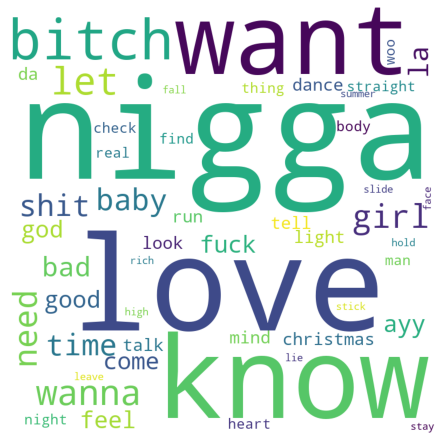

In [12]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white', relative_scaling=0.80,
                max_words=50).fit_words(keywords_2019_dict)

# plot the WordCloud image
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
wordcloud.to_file('../../data/output/top_words_2019.jpg')
plt.show()


In [13]:
keywords_2020_pt = pd.pivot_table(lyrics.loc[ids2020], index=['keyword_1'],
                                    values=['lyrics_id'],
                                    aggfunc={'lyrics_id' : 'count'})
keywords_2020_pt.sort_values(by='lyrics_id', inplace=True, ascending=False)
keywords_2020_pt

,lyrics_id
keyword_1,
know,59
nigga,53
bitch,28
love,27
want,18
...,...
lifestyle,1
listen,1
lonely,1


In [14]:
keywords_2020_dict = {}
for row in keywords_2020_pt.itertuples():
    keywords_2020_dict[row[0]] = row[1]

keywords_2020_dict


{'know': 59,
 'nigga': 53,
 'bitch': 28,
 'love': 27,
 'want': 18,
 'ayy': 13,
 'time': 12,
 'girl': 10,
 'shit': 10,
 'la': 10,
 'come': 9,
 'wanna': 9,
 'let': 9,
 'baby': 8,
 'run': 6,
 'woo': 5,
 'look': 5,
 'fuck': 5,
 'good': 5,
 'man': 5,
 'tell': 5,
 'pussy': 5,
 'need': 5,
 'night': 5,
 'way': 5,
 'christmas': 5,
 'na': 4,
 'hit': 4,
 'hope': 4,
 'da': 4,
 'feel': 4,
 'shoot': 4,
 'big': 4,
 'bad': 4,
 'turn': 3,
 'mad': 3,
 'thing': 3,
 'think': 3,
 'leave': 3,
 'happy': 3,
 'mm': 3,
 'hold': 3,
 'money': 3,
 'country': 3,
 'stay': 3,
 'like': 3,
 'young': 3,
 'break': 3,
 'gang': 3,
 'life': 3,
 'lil': 3,
 "goin'": 3,
 'hot': 3,
 'friend': 2,
 'hard': 2,
 'head': 2,
 'talk': 2,
 'drink': 2,
 'hate': 2,
 'room': 2,
 'dumb': 2,
 'watch': 2,
 'beer': 2,
 'believe': 2,
 'little': 2,
 'bed': 2,
 'god': 2,
 'straight': 2,
 'guy': 2,
 'heart': 2,
 'hallelujah': 2,
 'santa': 2,
 'stick': 2,
 'lo': 2,
 'stop': 2,
 'road': 2,
 'doo': 2,
 'jingle': 2,
 'real': 2,
 'body': 2,
 'try': 2,

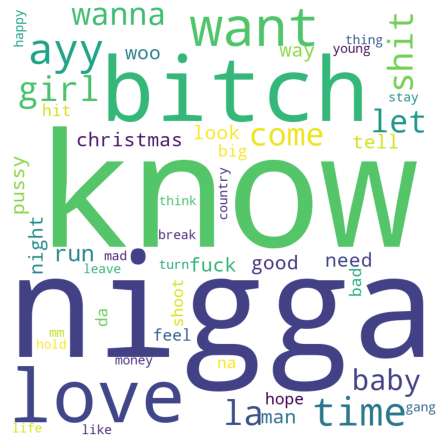

In [15]:
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white', relative_scaling=0.80,
                max_words=50).fit_words(keywords_2020_dict)

# plot the WordCloud image
plt.figure(figsize = (6, 6), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
wordcloud.to_file('../../data/output/top_words_2020.jpg')
plt.show()

In [16]:
lyrics.columns

Index(['billboard_id', 'lyrics_id', 'artist', 'first_artist', 'song',
       'weeks_on_chart', 'peak_rank', 'lyrics', 'url', 'length', 'word_count',
       'language', 'language_score', 'first_appearance', 'genius_id',
       'release_date', 'keywords', 'desc_keywords', 'keyword_1', 'keyword_2',
       'keyword_3', 'keyword_4', 'keyword_5'],
      dtype='object')

In [48]:
# covid_ids = bb_t100['lyrics_id'].loc[bb_t100['date'] >= '2020-03-01'].unique()
# covid_ids

covid_ids = lyrics['lyrics_id'].loc[lyrics['release_date'] >= '2020-03-01'].unique()
missing_release_dates = lyrics['lyrics_id'].loc[lyrics['release_date'].isna()].unique()
for lyrics_id in missing_release_dates:
    if lyrics['first_appearance'].loc[lyrics_id] >= '2020-03-01':
        print(lyrics_id)
        covid_ids = np.append(covid_ids, lyrics_id)

covid_ids = list(set(covid_ids))
covid_ids

825
861
881
899
975
978
985
1005
1029
1055
1082
1109
1118
1144
1213
1215
1256
1274
1280
1281
1292
1310
1315
1317


[640,
 696,
 738,
 748,
 772,
 773,
 774,
 775,
 776,
 777,
 778,
 779,
 780,
 781,
 782,
 783,
 784,
 785,
 786,
 787,
 789,
 790,
 791,
 792,
 793,
 794,
 795,
 796,
 797,
 798,
 799,
 800,
 801,
 802,
 804,
 805,
 806,
 808,
 810,
 811,
 813,
 814,
 815,
 816,
 817,
 818,
 819,
 820,
 821,
 822,
 824,
 825,
 826,
 827,
 828,
 829,
 830,
 832,
 834,
 835,
 836,
 837,
 838,
 839,
 840,
 842,
 843,
 844,
 846,
 848,
 849,
 850,
 851,
 852,
 856,
 859,
 861,
 862,
 863,
 864,
 865,
 866,
 867,
 868,
 869,
 870,
 871,
 872,
 873,
 874,
 875,
 876,
 878,
 879,
 880,
 881,
 882,
 883,
 884,
 886,
 887,
 888,
 890,
 891,
 892,
 893,
 894,
 896,
 897,
 898,
 899,
 900,
 901,
 902,
 903,
 905,
 906,
 907,
 908,
 909,
 910,
 912,
 913,
 914,
 915,
 916,
 917,
 918,
 919,
 920,
 921,
 922,
 923,
 924,
 925,
 926,
 927,
 928,
 929,
 930,
 931,
 932,
 933,
 934,
 935,
 936,
 937,
 938,
 939,
 940,
 941,
 942,
 943,
 944,
 945,
 946,
 947,
 948,
 949,
 950,
 951,
 952,
 954,
 955,
 956,
 957,
 959

In [25]:
pd.set_option('display.max_rows', 40)
lyrics.sort_values(by=['release_date'])

,billboard_id,lyrics_id,artist,first_artist,song,weeks_on_chart,peak_rank,lyrics,url,length,...,first_appearance,genius_id,release_date,keywords,desc_keywords,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5
15,15,15,Gene Autry,Gene Autry,Rudolph The Red-Nosed Rein...,12.0,16.0,"You know Dasher, and Dance...",https://genius.com/Gene-au...,1060,...,2019-01-05,512798.0,1949-09-01,"{'reindeer': 11, 'rudolph'...",{'nan': 1},reindeer,rudolph,red,nosed,nose
1309,10435,1309,Bing Crosby & The Andrews ...,Bing Crosby,Mele Kalikimaka (Merry Chr...,1.0,36.0,Mele Kalikimaka is the thi...,https://genius.com/Bing-cr...,1189,...,2021-01-02,303219.0,1950-01-01,"{'christmas': 13, 'mele': ...","{'hawaiian': 3, 'title': 2...",christmas,mele,kalikimaka,bright,day
39,39,39,Elvis Presley,Elvis Presley,Blue Christmas,3.0,33.0,I'll have a blue Christmas...,https://genius.com/Elvis-p...,650,...,2019-01-05,197055.0,1957-10-15,"{'blue': 12, 'christmas': ...","{'recording': 3, 'mille': ...",blue,christmas,start,doin',white
7,7,7,Bobby Helms,Bobby Helms,Jingle Bell Rock,35.0,3.0,"Jingle bell, jingle bell, ...",https://genius.com/Bobby-h...,1013,...,2019-01-05,623112.0,1957-11-28,"{'jingle': 28, 'bell': 23,...",{'good': 1},jingle,bell,time,rock,horse
630,5244,630,Dean Martin,Dean Martin,Baby It's Cold Outside,1.0,45.0,"I really can't stay (But, ...",https://genius.com/Dean-ma...,1815,...,2020-01-04,1019169.0,1959-08-06,"{'baby': 8, 'cold': 8, 'st...","{'cold': 1, 'outside': 1, ...",baby,cold,stay,look,drop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281,10300,1281,Taylor Swift,Taylor Swift,Willow,2.0,1.0,I'm like the water when yo...,https://genius.com/Taylor-...,1983,...,2020-12-26,6260155.0,NaN,"{'man': 13, 'know': 9, 'be...","{'album': 4, 'willow': 3, ...",man,know,beg,hand,wreck
1292,10356,1292,Taylor Swift Featuring Bon...,Taylor Swift,Evermore,1.0,57.0,Gray November\nI've been d...,https://genius.com/Taylor-...,1733,...,2020-12-26,6260141.0,NaN,"{'catch': 5, 'pain': 4, 't...","{'track': 3, 'period': 2, ...",catch,pain,think,breath,sure
1310,10438,1310,Donny Hathaway,Donny Hathaway,This Christmas,1.0,39.0,Hang all the mistletoe\nI'...,https://genius.com/Donny-h...,906,...,2021-01-02,1151232.0,NaN,"{'christmas': 14, 'merry':...",{'nan': 1},christmas,merry,shake,hand,fireside
1315,10449,1315,Bing Crosby,Bing Crosby,I'll Be Home For Christmas,1.0,50.0,I'll be home for Christmas...,https://genius.com/Bing-cr...,409,...,2021-01-02,1390068.0,NaN,"{'christmas': 6, 'plan': 2...",{'nan': 1},christmas,plan,snow,mistletoe,present


In [32]:
# corona_keywords = ['antidote', 'contact', 'contracting', 'corona', 'coronavirus', 'cough', 'covid', 'cure',
#                    'distancing', 'flu', 'hazmat', 'hospitable', 'ill', 'mask', 'pandemic', 'quarantine', 'sars',
#                    'sick', 'solitary', 'symptom', 'threat', 'virus', 'wave']

corona_keywords = ['antidote', 'contracting', 'corona', 'coronavirus', 'cough', 'covid', 'distancing', 'flu', 'hazmat',
                   'hospitable', 'mask', 'pandemic', 'quarantine', 'sars', 'symptom', 'virus']


def is_corona_song(keywords):
    for word in corona_keywords:
        if word in keywords:
            return True
    return  False


In [49]:
lyrics['is_corona_song'] = lyrics['keywords'].apply(lambda keywords: is_corona_song(keywords))
corona_lyrics = lyrics.loc[covid_ids].loc[lyrics['is_corona_song'] == True]
corona_lyrics.to_excel('../../data/output/corona_lyrics_bb.xlsx', encoding='utf-8')
corona_lyrics


,billboard_id,lyrics_id,artist,first_artist,song,weeks_on_chart,peak_rank,lyrics,url,length,...,genius_id,release_date,keywords,desc_keywords,keyword_1,keyword_2,keyword_3,keyword_4,keyword_5,is_corona_song
783,6335,783,Lil Uzi Vert,Lil Uzi Vert,You Better Move,1.0,36.0,What's happening?\nRemembe...,https://genius.com/Lil-uzi...,2731,...,5324263.0,2020-03-06,"{'shoot': 5, 'shoe': 4, 'g...","{'song': 3, 'sample': 3, '...",shoot,shoe,girl,louis,pull,True
791,6375,791,Lil Uzi Vert Featuring Syd,Lil Uzi Vert,Urgency,1.0,76.0,Treat my darkskin like my ...,https://genius.com/Lil-uzi...,2197,...,5324255.0,2020-03-06,"{'redbone': 9, 'tell': 7, ...","{'uzi': 3, 'track': 3, 'sy...",redbone,tell,know,phone,treat,True
804,6471,804,Lil Uzi Vert Featuring NAV,Lil Uzi Vert,Leaders,1.0,72.0,"Tourin', I'm sellin' out s...",https://genius.com/Lil-uzi...,3855,...,5346315.0,2020-03-13,"{'hit': 8, 'girl': 7, 'g':...","{'uzi': 3, 'nav': 3, 'albu...",hit,girl,g,lil,know,True
850,6822,850,twenty one pilots,twenty one pilots,Level Of Concern,11.0,23.0,"Need you, tell me\nNeed yo...",https://genius.com/Twenty-...,2141,...,5428841.0,2020-04-09,"{'tell': 38, 'need': 19, '...","{'song': 5, 'tylers': 3, '...",tell,need,okay,alright,level,True
851,6853,851,Tory Lanez,Tory Lanez,Stupid Again,1.0,54.0,I just wanna say from the ...,https://genius.com/Tory-la...,3232,...,5439315.0,2020-04-10,"{'bitch': 15, 'fuck': 14, ...",{},bitch,fuck,shit,woo,nigga,True
861,6908,861,DaBaby Featuring Roddy Ricch,DaBaby,Rockstar,35.0,1.0,"Woo, woo\nI pull up like\n...",https://genius.com/Dababy-...,3148,...,6980680.0,NaN,"{'nigga': 14, 'woo': 12, '...",{'nan': 1},nigga,woo,let,pull,cop,True
867,6952,867,DaBaby Featuring Future & ...,DaBaby,LIGHTSKIN SHIT,1.0,53.0,"Uh, uh, uh-huh\nYeah (Oh L...",https://genius.com/Dababy-...,2550,...,5465365.0,2020-04-17,"{'bitch': 16, 'fuck': 8, '...","{'track': 2, 'future': 2, ...",bitch,fuck,shit,sick,pop,True
879,7010,879,Juice WRLD,Juice WRLD,Righteous,16.0,11.0,I will (I will)\nI will (I...,https://genius.com/Juice-w...,1716,...,4673513.0,2020-04-24,"{'know': 6, 'time': 5, 'pi...","{'juice': 4, 'song': 4, 'j...",know,time,pill,codeine,ice,True
903,7150,903,Drake,Drake,Losses,1.0,51.0,"Hey, Instagram\nThis song ...",https://genius.com/Drake-l...,3064,...,5520818.0,2020-05-01,"{'know': 6, 'game': 4, 'ni...","{'track': 3, 'loss': 1, 'd...",know,game,nigga,hold,day,True
907,7164,907,Lil Baby,Lil Baby,Social Distancing,1.0,65.0,(Section 8 just straight c...,https://genius.com/Lil-bab...,2655,...,5519310.0,2020-05-01,"{'nigga': 10, 'sick': 6, '...","{'track': 4, 'baby': 3, 's...",nigga,sick,send,good,social,True


In [ ]:
corona_keywords =[]
for keywords in corona_lyrics['keywords']:
    for key in keywords:
        if not key in corona_keywords:
            corona_keywords.append(key)

print(sorted(corona_keywords))


In [ ]:
doc = nlp('walked')
doc[0].lemma_
